# Runs par file and puts output in Pedsim Folder

In [1]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt

### Do the Arial 
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/ped-sim/"  # The Path on Midway Cluster
elif socket_name.startswith("Harald-Laptop"):
    print("Harald's new laptop detected!")
    path = "/home/hringbauer/git/ped-sim/" 
if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/ped-sim/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./package/")  # Go to the hapsburg package directory

from hapsburg.PackagesSupport.pp_individual_roh_csvs import post_process_roh_df, combine_ROH_df, calc_average_roh
from hapsburg.figures.plot_bars import plot_panel_row, prepare_dfs_plot, create_cousins_roh

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

compute-a-16-142.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/ped-sim
CPU Count: 32


# Installation Notes Pedsim
git clone ...

module load boost

make

In [2]:
def run_pedsim(par_file="par/ibd/gp1.def",
               output="output/ibd/gp1",
               gmap="refined_mf.simmap",
               o_file="output/ibd/gp1",
               i_file="interfere/nu_p_campbell.tsv"):
    """Wrapper to run pedsim"""
    !./ped-sim -d $par_file -m $gmap -o $output --intf $i_file

In [10]:
%%time
### First cousin offspring
run_pedsim(par_file="par/roh/roh_1st_cousin.def", output="output/roh/c1")

Pedigree simulator!  v1.1.16    (Released  8 Feb 2021)

  Def file:		par/roh/roh_1st_cousin.def
  Map file:		refined_mf.simmap
  Input VCF:		[none: no genetic data]
  Output prefix:	output/roh/c1

  Random seed:		479928826

  Interference file:	interfere/nu_p_campbell.tsv

Simulating haplotype transmissions... done.
Printing IBD segments... done.

To simulate genetic data, must use an input VCF with 4000 founders.
CPU times: user 62 ms, sys: 24.2 ms, total: 86.2 ms
Wall time: 2.07 s


In [11]:
%%time
### Simulate 2nd cousins
run_pedsim(par_file="par/roh/roh_2nd_cousin.def", output="output/roh/c2")

Pedigree simulator!  v1.1.16    (Released  8 Feb 2021)

  Def file:		par/roh/roh_2nd_cousin.def
  Map file:		refined_mf.simmap
  Input VCF:		[none: no genetic data]
  Output prefix:	output/roh/c2

  Random seed:		2813027466

  Interference file:	interfere/nu_p_campbell.tsv

Simulating haplotype transmissions... done.
Printing IBD segments... done.

To simulate genetic data, must use an input VCF with 6000 founders.
CPU times: user 54.9 ms, sys: 16.4 ms, total: 71.3 ms
Wall time: 1.66 s


In [13]:
### Simulate Half Sibling Offspring
run_pedsim(par_file="par/roh/roh_halfsib.def", output="output/roh/h1")

Pedigree simulator!  v1.1.16    (Released  8 Feb 2021)

  Def file:		par/roh/roh_halfsib.def
  Map file:		refined_mf.simmap
  Input VCF:		[none: no genetic data]
  Output prefix:	output/roh/h1

  Random seed:		1935908850

  Interference file:	interfere/nu_p_campbell.tsv

Simulating haplotype transmissions... done.
Printing IBD segments... done.

To simulate genetic data, must use an input VCF with 3000 founders.


# Process PEDSIM output

In [12]:
def load_segment_file(path_segments="../ped-sim/output/output.seg",
                      roh_only=False, cm_fac=0.01):
    """Load and return segment File of IBD & ROH blocks.
    Return Pandas dataframe. 
    roh_only: Only load ROH blocks
    cm_fac: Factor with which to multiply genetic length columns"""
    df = pd.read_csv(path_segments, sep="\t", header=None)
    df.columns = ["iid1", "iid2", "ch", "Start", "End", 
                  "ibd_stat", "StartM", "EndM", "lengthM"]
    df["length"] = (df["End"] - df["Start"])
    
    for col in ["StartM", "EndM", "lengthM"]:
        df[col] = df[col] * cm_fac
        
    if roh_only:
        df = extract_roh_df(df)
    return df

def extract_roh_df(df, col="ibd_stat", stat="HBD"):
    """Extract and return Dataframe of ROH segments 
    in hapsburg format"""
    df = df[df[col]==stat]
    df = df.drop(columns="iid2")
    df = df.rename(columns={"iid1": "iid"})
    return df

def to_hapsburg_df(path_segments = "../ped-sim/output/test.seg", clst="1st_cousin",
                   savepath = "", n=500,
                   min_cm=[4, 8, 12, 20], snp_cm=100,
                   gap=0.5, min_len1=2, min_len2=4,
                   output=False, sort=True):
    """Load pd_sim output and post_process into Hapsburg
    Summary output. Return this dataframe.
    If savepath is given, save to there (tab-seperated)"""
    df1 = load_segment_file(path_segments, roh_only=True)  # Load the full segment file, transfomred

    ### Split up into lists of Dataframes
    grouped = df1.groupby(['iid'])
    df_rohs = [x[1] for x in list(grouped)] 
    iids = [x[0] for x in list(grouped)]
    
    ### Add Individuals with 0 ROH
    iids1 = ["iid" + str(i) for i in range(len(iids),n)]
    df_rohs1 = [pd.DataFrame(columns = df1.columns) for _ in range(len(iids),n)]
    
    iids = iids + iids1
    df_rohs = df_rohs + df_rohs1
    
    ### Create the combine Dataframe
    df_roh = combine_ROH_df(df_rohs, iids=iids, pops=clst, 
             min_cm=min_cm, snp_cm=snp_cm,
             gap=gap, min_len1=min_len1, min_len2=min_len2,
             output=output, sort=sort)
    
    ### Some Minor Updates to stay compatible with hapsburg 
    # Full Format
    df_roh["age"]=0
    df_roh["clst"] = df_roh["pop"]
    
    if len(savepath)>0:
        df_roh.to_csv(savepath, sep="\t", index=False)
        print(f"Saved to: {savepath}")    
    return df_roh, df1

In [14]:
%%time
df1, df11 = to_hapsburg_df(path_segments = "./output/roh/c1.seg", 
                     clst="1st_cousin", savepath="./output/roh/c1.tsv", n=1000)

Saved to: ./output/roh/c1.tsv
CPU times: user 1min 28s, sys: 76 ms, total: 1min 28s
Wall time: 1min 28s


In [15]:
%%time
df2, df22 = to_hapsburg_df(path_segments = "./output/roh/c2.seg", 
                     clst="2nd_cousin", savepath="./output/roh/c2.tsv", n=1000)

Saved to: ./output/roh/c2.tsv
CPU times: user 34.6 s, sys: 36.8 ms, total: 34.7 s
Wall time: 34.7 s


In [16]:
%%time
df3, df33 = to_hapsburg_df(path_segments = "./output/roh/h1.seg", 
                     clst="halfsib", savepath="./output/roh/h1.tsv", n=1000)

Saved to: ./output/roh/h1.tsv
CPU times: user 2min 1s, sys: 703 ms, total: 2min 1s
Wall time: 2min 1s


In [17]:
### Save csv files
df11.to_csv("./output/roh/c1_roh.csv", index=False)
df22.to_csv("./output/roh/c2_roh.csv", index=False)
df33.to_csv("./output/roh/h1_roh.csv", index=False) 

# Do hapROH Plotting

Saved figure to ./figs/n100_hs_c1_c2_offspring.pdf


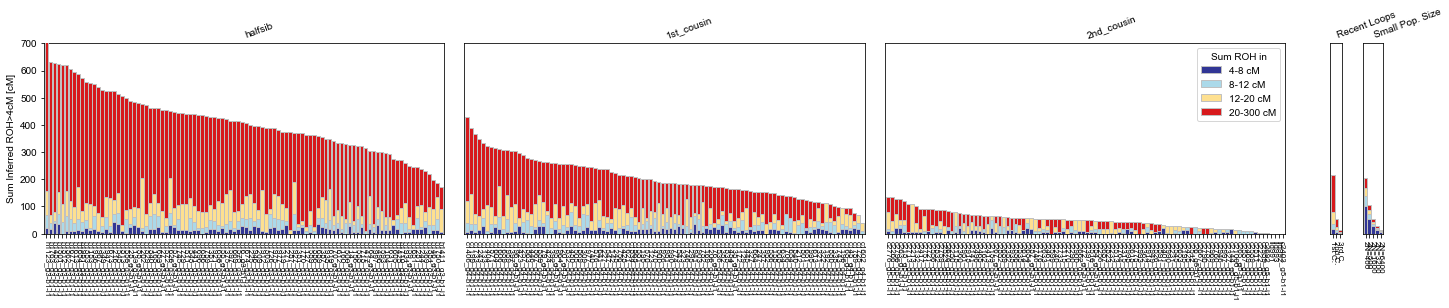

In [22]:
df1 = pd.read_csv("./output/roh/c1.tsv", sep="\t")
df2 = pd.read_csv("./output/roh/c2.tsv", sep="\t")
df3 = pd.read_csv("./output/roh/h1.tsv", sep="\t")

dfs_plot = [df.sample(n=100).sort_index() for df in [df3, df1,df2]]

#df1 = pd.read_csv("./Empirical/Eigenstrat/Example/combined_roh05.csv", sep='\t')
#plot_dfs, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])

# ./figures_test/freilich20_bars.pdf
plot_panel_row(dfs_plot, wspace=0.1, r_title=20, leg_pos=-1, 
               ylim=[0,700], figsize=(24,3.5), savepath="./figs/n100_hs_c1_c2_offspring.pdf")